In [1]:
import json
import pandas as pd
from sklearn import preprocessing
import numpy as np
import cv2
from torchvision.io import read_image
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.path as mplpath
import torch.utils.data as data_utils
import matplotlib.patches as patches
from pathlib import Path

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## DATA PREP 1

In [3]:
def data(file_dir_path):
    
    with open(file_dir_path) as j_file:
        list_of_marks = [] 
        json_list = list(j_file)
        p = 0 
        final = {}
        for json_str in json_list:
            if p > 50: #for relavative batch, for testing
                return final #, list_of_marks
            img = json.loads(json_str)
            img_id = img['image_id']+'.jpg'
            l_poly = []
            
            for key, value in img.items():
                for v in img['annotations']: #all annotations per image

                    for dic in v:
                        if dic['is_chinese']:
                           # print(dic['is_chinese'])
                            coords = dic['polygon']
                            l_poly.append(coords)
                        
 #                           text = dic['text'] #for specific rather than 1/0 inside BB
#                            list_of_marks.append(text) #for specific mark 

                              
            p += 1
            final[img_id] = l_poly
                    
    return final 

In [4]:
poly_box = data('a1/train.jsonl')

In [5]:
def make_box(poly_boxes):
    tp = []
    for img_id,boxes in poly_boxes.items():
        print('New Image for processing ... ')
        img = cv2.imread('a1/images/'+img_id)
        img = np.resize(img, (3 , 2048, 2048)) #2
#        img = np.resize(img, (2048*2048,2))
        grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
        grid = grid.reshape(2048*2048,2) 
        collected_poly = np.zeros(grid.shape[0])
        for box in boxes:
            pnts= np.array(box)
            path = mplpath.Path(pnts)
            new_new = path.contains_points(grid)
            new_new = np.array(new_new, int)
            collected_poly = np.maximum(collected_poly, new_new)
        img = img/255
        tp.append([img, collected_poly])
    
        

    return tp



In [6]:
mkb = make_box(poly_box)

New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image 

In [7]:
dataset = mkb

In [8]:
#Make Train, test, val
test_size = int(len(dataset)*0.2)

val_size = int(len(dataset)*0.1)
train_size = len(dataset) - (test_size+val_size)

train_d = dataset[:train_size] # 07
val_d = dataset[train_size:-test_size] #01
test_d = dataset[(train_size+val_size):] # 02 

#Train
trainloader = torch.utils.data.DataLoader(train_d, batch_size=5,
                                          shuffle=True, num_workers=2)

#Test
testloader = torch.utils.data.DataLoader(test_d, batch_size=5,
                                          shuffle=False, num_workers=2)



## MODEL 1

In [9]:
class ChineseChar(nn.Module):

    def __init__(self):
        super(ChineseChar, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5) 
        self.conv2 = nn.Conv2d(3, 16, 5)
        
        self.fc1 = nn.Linear(4145296, 253)  # for 1 dim: 16*253*253, 120
        self.fc2 = nn.Linear(253, 120) #120, 84
        self.fc3 = nn.Linear(120, 64) #84,16*256*256 eller 84,2  # 60 #4194304

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [10]:
Char = ChineseChar()

In [11]:

criterion = nn.BCELoss()
optimizer = optim.SGD(Char.parameters(), lr=0.005, momentum=0.9)

## Test 

In [12]:
num_epoch = 10
for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data 
        inputs = inputs.to(torch.float)
        labels = labels.to(torch.float)
        



        labels = torch.flatten(labels, 1)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = Char(inputs)

        #print(labels.shape)
        upsampling_alg = nn.Upsample(size=2048*2048)
        outputs = upsampling_alg(outputs.unsqueeze(1))
        enhanced_img = upsampling_alg(outputs.reshape(len(inputs), 1, 2048*2048))
        
        enhanced_img = enhanced_img.squeeze(1)
        
        
        #outputs = predicted.squeeze(-1) #if output in BCE set to < len-size of flatten array      
        

        #labels = torch.max(labels, 1)[1].long() # if more than 2 outputs in model, enable here #0 for 0's prints none
#        loss = criterion(outputs, labels)
        loss = criterion(enhanced_img, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('Epoch [{}/{}], Loss: {}'.format(epoch+1, num_epoch, loss.item()))
print('Finished Training')

/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Loss: 0.5863032937049866
Epoch [2/10], Loss: 0.21119970083236694
Epoch [3/10], Loss: 0.048833709210157394
Epoch [4/10], Loss: 0.02527598664164543
Epoch [5/10], Loss: 0.04726000502705574
Epoch [6/10], Loss: 0.030520491302013397
Epoch [7/10], Loss: 0.019646162167191505
Epoch [8/10], Loss: 0.02794039621949196
Epoch [9/10], Loss: 0.009800591506063938
Epoch [10/10], Loss: 0.024047497659921646
Finished Training


In [13]:
#Save model
#PATH = 'ModelType1'
#torch.save(Char.state_dict(), PATH)




In [14]:
#load
#PATH = 'ModelType1'
#Char = ChineseChar()
#Char.load_state_dict(torch.load(PATH))


In [15]:
np.set_printoptions(threshold=np. inf)

correct = 0
total = 0
Char.eval()
running_loss = 0

with torch.no_grad():
    for i, data in enumerate(testloader):
        
        imgs, labels = data
                
        imgs = imgs.to(torch.float)
        labels = labels.to(torch.float)
        labels = torch.flatten(labels, 1)
        
        outputs = Char(imgs)
        upsampling_alg = nn.Upsample(size=2048*2048)
        enhanced = upsampling_alg(outputs.unsqueeze(1))

        loss = criterion(enhanced.squeeze(), labels)
        running_loss = loss.item()
        total += labels.shape[0]
        
        correct += torch.sum(torch.eq(torch.argmax(enhanced, dim=1), labels))
        accuracy = int(correct) / ((i+1) * 5 * 3*2048*2048)

print('Accuracy:', round(accuracy,2))
print('Loss: ', running_loss)
        

Accuracy: 0.33
Loss:  0.05392131209373474


## Predictions

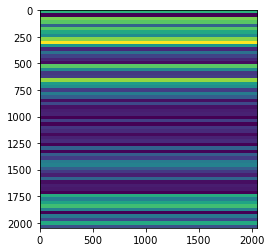

In [16]:
import random
r_img = random.choice(val_d)
p_img = torch.tensor(r_img[0]).permute(2,1,0) #0 for img, 1 for label
random_img = p_img.unsqueeze(0).permute(0,3,2,1).float() #to fake a batch-size for the model

with torch.no_grad():
    single_out = Char(random_img)

upsampling_alg = nn.Upsample(size=2048*2048) #original image size
enhanced_image = upsampling_alg(single_out.reshape(1,1,64)) #1 batch, 1 channel, img*img long
enhanced_img = enhanced_image.reshape(2048,2048) #Collect into colour-arrays
enhanced_img = enhanced_img.squeeze() #squeeze batch
plt.imshow(p_img)
plt.imshow(enhanced_img)
